In [2]:
import re
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline

/Users/jeremy/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load Fuana Dataset

In [85]:
df = pd.read_csv('../data/fauna.csv.gz', compression='gzip')
df.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
0,amphibia,ranidae,rana,animalia,anura,3451749,chordata,rboylii,The foothill yellow-legged frog (Rana boylii) ...,Foothill yellow-legged frog
1,amphibia,ranidae,lithobates,animalia,anura,38082824,chordata,lsylvaticus,This is a redirect from a title with another m...,Wood Frog
2,mammalia,bovidae,pantholopshodgson18342,animalia,artiodactyla,1369072,chordata,phodgsonii,The Tibetan antelope or chiru (Pantholops hodg...,Tibetan antelope
3,mammalia,bovidae,damaliscus,animalia,artiodactyla,26625724,chordata,dsuperstes,The Bangweulu tsessebe (Damaliscus superstes) ...,Bangweulu tsessebe
4,mammalia,tayassuidae,catagonusameghino1904,animalia,artiodactyla,1709509,chordata,cbrachydontuscmetropolitanuscstenocephaluscwag...,The Chacoan peccary or tagua (Catagonus wagner...,Chacoan peccary


## Visualize the number of records in each class

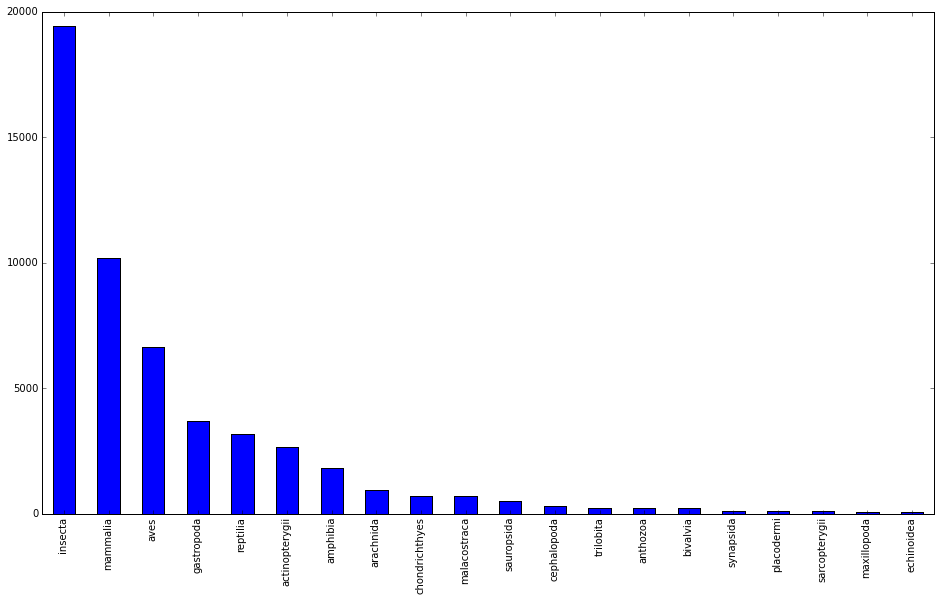

In [4]:
classes = df['class'].value_counts()
figure(figsize=(16, 9))
classes[0:20].plot(kind="bar")

In [96]:
df[df['page-id']==217427]

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
53,NaN,NaN,NaN,animalia,therapsida,217427,chordata,NaN,NaN,Eucynodonts


In [5]:
df.set_index(keys=['page-id'])

,class,family,genus,kingdom,order,phylum,species,text,title
page-id,,,,,,,,,
3451749,amphibia,ranidae,rana,animalia,anura,chordata,rboylii,The foothill yellow-legged frog (Rana boylii) ...,Foothill yellow-legged frog
38082824,amphibia,ranidae,lithobates,animalia,anura,chordata,lsylvaticus,This is a redirect from a title with another m...,Wood Frog
1369072,mammalia,bovidae,pantholopshodgson18342,animalia,artiodactyla,chordata,phodgsonii,The Tibetan antelope or chiru (Pantholops hodg...,Tibetan antelope
26625724,mammalia,bovidae,damaliscus,animalia,artiodactyla,chordata,dsuperstes,The Bangweulu tsessebe (Damaliscus superstes) ...,Bangweulu tsessebe
1709509,mammalia,tayassuidae,catagonusameghino1904,animalia,artiodactyla,chordata,cbrachydontuscmetropolitanuscstenocephaluscwag...,The Chacoan peccary or tagua (Catagonus wagner...,Chacoan peccary
3512831,NaN,NaN,chingkankousaurusyoung1958,animalia,saurischia,chordata,cfragilis,"Chingkankousaurus (named for Ch'ing-kang-kou, ...",Chingkankousaurus
262734,aves,opisthocomidae,opisthocomusilliger1811,animalia,opisthocomiformes,chordata,ohoazin,"The hoatzin (Opisthocomus hoazin), also known ...",Hoatzin
3392087,mammalia,dasyproctidae,dasyprocta,animalia,rodentia,chordata,dfuliginosa,"The black agouti, Dasyprocta fuliginosa, is a ...",Black agouti
18936840,mammalia,bovidae,capricornis,animalia,artiodactyla,chordata,cthar,The Himalayan serow (Capricornis thar) also kn...,Himalayan serow


### Create a TFIDF Table

In [77]:
count = 0
limit = 100               # limit the number of documents we scan
doc_freq = {}             # doc_freq['word'] += 1
term_freq = {}            # term_freq[234234] = {'word' : count}
word_count_history = []

for index, row in df.iterrows():
    if count < limit and row['text'] != '':
        count += 1
        page_id = row['page-id']
        if page_id in term_freq:
            terms = term_freq[page_id]
        else:
            terms = term_freq[page_id] = {}
        
        # find all words, ignore numbers, special characters and new lines/spaces/etc...
        s = str(row['text']).lower()
        word_list = re.findall(r'\b[^\W\d_]+\b', s)
        
        for word in word_list:
            if word in terms:
                terms[word] += 1
            else:
                terms[word] = 1
            
            if word in doc_freq:
                doc_freq[word].add(page_id)
            else:
                doc_freq[word] = set()
                doc_freq[word].add(page_id)
                
        word_count_history.append(len(doc_freq))

In [119]:
len(doc_freq['a'])

82

In [101]:
doc_freq

{'uplands': {230271},
 'naris': {620629},
 'williams': {2817885},
 'philtrum': {464545},
 'contains': {25409,
  50185,
  54177,
  201968,
  322578,
  370611,
  439344,
  1369072,
  3535047,
  4958551,
  17378563,
  18814740,
  22877357},
 'chhurpi': {230271},
 'pennsylvania': {4401, 2925388},
 'gregory': {195481, 591661, 4298246, 5032539},
 'appearance': {4401,
  322578,
  369995,
  370611,
  464545,
  620629,
  2494915,
  3157567,
  3444288,
  3451749,
  10040835},
 'ammodytes': {4401},
 'retial': {20733467},
 'hummingbirds': {262734},
 'drown': {4401, 53484, 370611},
 'elaborately': {54177},
 'sauropterygians': {25409},
 'basing': {2925388, 7001272},
 'sustained': {4401, 25409},
 'incubation': {4401, 25409, 2017415},
 'clash': {54177},
 'pareiasaurus': {42223406},
 'infrequently': {322578},
 'helps': {50185, 65195, 230271, 322578, 12516415, 20733467},
 'older': {4401, 25409, 195481, 201968, 322578, 464545, 3451749, 40996456},
 'host': {25409, 50185, 322578},
 'forages': {322578},
 's

In [145]:
from math import log
tf = pd.DataFrame(term_freq)
tf = tf.fillna(0)
tf = tf.apply(lambda x : x / tf.shape[0])   # normalize term frequency against number of documents

doc_freq_counts = {}
for word in doc_freq:
    if word not in doc_freq_counts:
        doc_freq_counts[word] = len(doc_freq[word])
        
idf = pd.Series(doc_freq_counts)
idf.head()
#idf = idf.apply(lambda x : len(doc_freq) / log(x))

a            82
abandon       1
abandoned     2
abang         1
abbott        1
dtype: int64

### Just for fun, how does the number of words increase as we count occurences?

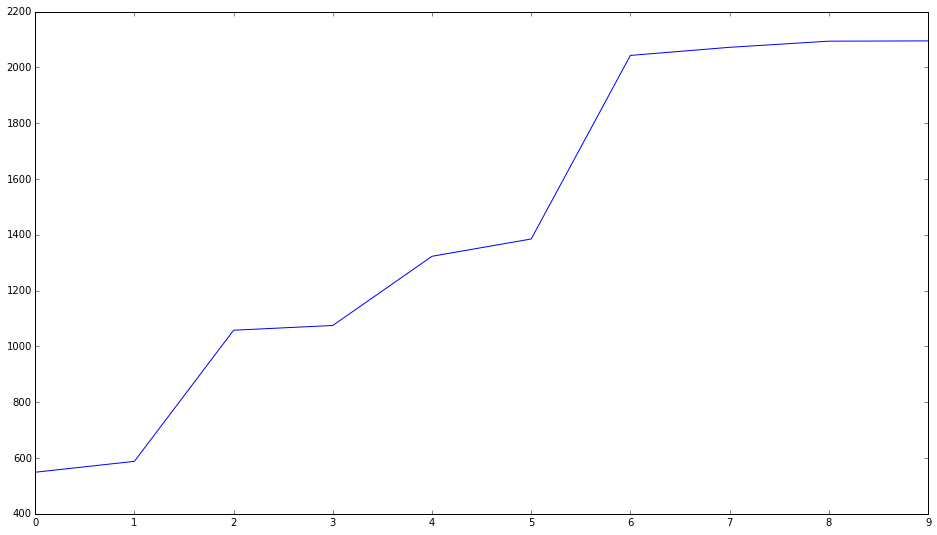

In [9]:
figure(figsize=(16, 9))
plot(word_count_history)